# Random Kitchen Sinks - experimental

## Introduction

In this notebook, we try to simulate our quantum-enhanced RKS algorithm run under more realistic conditions. We simulate sampling, threshold detection and circuit noise.

## Sampling

Our sampling is simluated by drawing outputs whose probabilities are defined by the SLOS probabilities.

In [1]:
def noisy_prob(s1, input_state):
    prob_vals=new_all_state_prob(s1, input_state, threshold_map, threshold_states)[1]
    if N_DRAW==float("inf"):
        return prob_vals
    sample=np.random.choice(np.arange(len(prob_vals)), size=(N_DRAW,), p=prob_vals)
    res=[]
    for i in range(len(prob_vals)):
        res.append(np.count_nonzero(sample==i))
    return np.array(res)/N_DRAW

## Parameters noise

Parameters noise takes into account the discretization of the controlling tension and other sources of noise which we call "thermic noise".

In [2]:
step = 6.5 * 1e-3 # increment of phase control
thermic_noise=1e-3 # thermic noise (includes other sources of noise)
N_DRAW=1000

In [3]:
def noisy_angle(angle):
    """
    Computes the angle observed by the phase shifter due to the discretization of the input voltage.
    """
    if step==0:
        return angle
    return angle - np.remainder(angle, step)

## Threshold detection

Here the problem can be pre-computed since we always input a fixed number of photons (namely $1$) on $2$ modes.

In [4]:
def convert_threshold(m, n):
    """
    Returns a list that maps each state to its threshold detection
    """
    s1=pcvl.BackendFactory().get_backend("SLOS")(pcvl.Matrix.random_unitary(m))
    states_list=list(s1.allstate_iterator(pcvl.BasicState([n] + [0]*(m - 1))))
    res=[]
    for state in states_list:
        state_list=list(state)
        threshold_state=[]
        for r in range(m):
            if state_list[r] > 0:
                threshold_state.append(1)
            else:
                threshold_state.append(0)
        res.append(pcvl.BasicState(threshold_state))
    return res

In [5]:
def idx_threshold(m, n):
    threshold_states=convert_threshold(m, n)
    
    list_bin=[list(map(int, list(str(bin(i))[2:]))) for i in range(1, 2**m)]
    for i in range(len(list_bin)):
        list_bin[i]=[0]*(m-len(list_bin[i])) + list_bin[i]
    list_bin=list(map(pcvl.BasicState, list_bin))
    
    res=[]
    for r in range(len(threshold_states)):
        for s in range(len(list_bin)):
            if list_bin[s]==threshold_states[r]:
                res.append(s)
    return res, list_bin

In [6]:
def new_all_state_prob(s1, input_state, threshold_map, threshold_states):
    s1.compile(input_state)
    probs_number=s1.all_prob(input_state)
    probs=np.zeros((len(threshold_states,)))
    
    for i in range((len(probs_number))):
        probs[threshold_map[i]]+=probs_number[i]
    return threshold_states, probs

## Use of a theoritical $\lambda$ for computing $x \mapsto \sqrt{2} \cos x$

It can be shown that the unitary matrix of our circuit is:

\begin{equation*}
\begin{pmatrix}
\frac{e^{ix} - 1}{2} & \frac{i(e^{ix} + 1)}{2} \\
\frac{i(e^{ix} + 1)}{2} & -\frac{e^{ix} - 1}{2} 
\end{pmatrix}
\end{equation*}

If we send a single photon, we get the following probabilites:

\begin{equation*}
|<1-m, m|\mathcal{U}(x)|1, 0>|^2 = \cos^{2m}\left(\frac{x}{2}\right) \sin^{2(n-m)}\left(\frac{x}{2}\right)
\end{equation*}

Hence:

\begin{equation*}
\sqrt{2} \cos x = \sqrt{2} \left(|<0, 1|\mathcal{U}(x)|1, 0>|^2 - |<1, 0|\mathcal{U}(x)|1, 0>|^2 \right)
\end{equation*}

In the remaining of our notebook, we use this theoretical value of $\lambda$.

One advantage of our approach is that threshold and number resolving detections are equivalent.

### Importation of modules

In [7]:
import numpy as np
import perceval as pcvl
import perceval.lib.symb as symb
from math import comb
import sklearn.datasets as skdt
import time
from scipy.optimize import basinhopping
from copy import deepcopy
import matplotlib.pyplot as plt
import pybobyqa
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from qiskit_machine_learning.datasets import ad_hoc_data
from qiskit.utils import algorithm_globals
from qiskit import BasicAer
from qiskit.circuit.library import ZZFeatureMap
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit_machine_learning.algorithms import QSVC
from qiskit_machine_learning.kernels import QuantumKernel
from sklearn.svm import SVC
from sklearn.cluster import SpectralClustering
from sklearn.metrics import normalized_mutual_info_score

### Definition of the constants, the circuit and the simulator

Instead of using the circuit of <a href="https://arxiv.org/abs/2107.05224v1">Gan et al</a>, we use a 3-mode circuit for generating $x \mapsto \sqrt{2} \cos{x}$.

In [8]:
training_set = [] # training vector of the kenrel
m = 2 # number of modes
n = 1 # number of photons
input_state = pcvl.BasicState([n, 0]) # |n, 0>
x_ri = pcvl.P("x_ri") # parameter x_r,i = gamma * (w_r . x_i + b_r)
k = 1
a = 6 # range of the lambda parameter
fock_dim = comb(n + m - 1, n) # dimension of the Fock subspace Phi_m,n
threshold_map, threshold_states=idx_threshold(m, n)

In [9]:
simulator_backend = pcvl.BackendFactory().get_backend("SLOS") # definition of the backend
s1 = simulator_backend(pcvl.Matrix.random_unitary(m)) # some matrix that will be changed later
s1.compile(input_state)
c=pcvl.Circuit(m=m).add((0,1), symb.BS()).add(0,symb.PS(x_ri)).add((0,1), symb.BS())
pcvl.pdisplay(c)

In [10]:
def quantum_value(xRI, lambda_random):
    """
    Wrapper that define the quantum circuit computation. It computes the noisy parameters of the circuit and the approximated
    value of the probabilities
    """
    x_ri.set_value(np.random.normal(loc=noisy_angle(xRI) % (2 * np.pi), scale=thermic_noise)) # set the new phase of the phase shifter
    U = c.compute_unitary(use_symbolic=False) # define the new circuit matrix
    s1.U = U # modify the unitary matrix of the simulator
    return np.sum(np.multiply(noisy_prob(s1, input_state), lambda_random)) # observable computation

### Definition of  constants

The value of $R$ is very important. It defines the expressivity of the circuit. On the one hand, a too small value leads to the under-fitting. On th other hand, a too large value leads to over-fitting. Moreover, the approximation of replacing the expectancy by the realization require a value high enough. For this reason, *the wrapper at the end of the notebook redefines its value according to the following (empircally found) rules*:

1. For linear datasets: $R = 3$
2. For circular datasets: $R = 20$
3. For lunar datasets: $R = 30$

As the reader may have noticed, some numbers are different from those of the ideal case. Indeed, it seems that noise and sampling (threshold detection plays no role in it) induce a loss of expressivity, which needs to be compensated by higher values of $R$.

In [11]:
h = .03    # step size in the mesh
gamma = 0.1 # scale parameter
R = 20   # this is the key value

#### Value of $\lambda$

This is the theoretical of $\lambda$ that was introduced earlier.

In [12]:
lambda_random =np.array([ np.sqrt(2), -np.sqrt(2), 0])

##### Comparaison of the real and the quantum functions

Due to noise and sampling, the values of the estimated and real functions differ slightly.

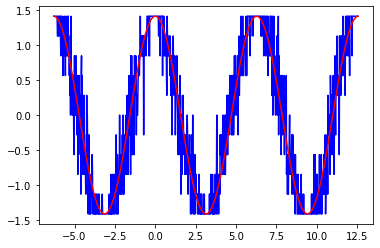

In [13]:
N_DRAW=10
X = np.linspace(-2 * np.pi, 4 * np.pi, num = 1000)
plt.plot(X, [quantum_value(x, lambda_random) for x in X], 'b')
plt.plot(X, np.sqrt(2) * np.cos(X), 'r')
plt.show()

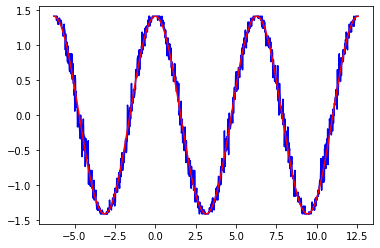

In [14]:
N_DRAW=100
X = np.linspace(-2 * np.pi, 4 * np.pi, num = 1000)
plt.plot(X, [quantum_value(x, lambda_random) for x in X], 'b')
plt.plot(X, np.sqrt(2) * np.cos(X), 'r')
plt.show()

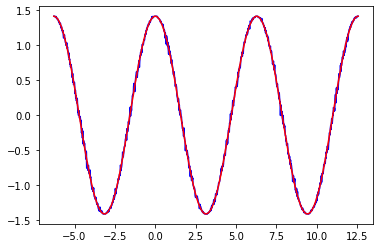

In [15]:
N_DRAW=1000
X = np.linspace(-2 * np.pi, 4 * np.pi, num = 1000)
plt.plot(X, [quantum_value(x, lambda_random) for x in X], 'b')
plt.plot(X, np.sqrt(2) * np.cos(X), 'r')
plt.show()

### Data generation

The input points are normalized in order to make the graphical representation easier.

In [16]:
def normalizeX(z):
    """
    Sets the values between -1 and 1 linearly
    """
    zmax = np.max(z)
    zmin = np.min(z)
    return 2 * (z - zmin) / (zmax - zmin) - 1

def normalizey(z):
    """
    Values between -1 and 1 by replacing 0 values by -1
    """
    for i in range(len(z)):
        if z[i] == 0:
            z[i] = -1
    return z

def generate_data(type, N, noise_param):
    """
    Generates random datasets of different types
    type == 0: linear dataset
    type == 1: circular dataset
    type == 2: lunar dataset
    
    >> Default noise values:
        - linear dataset: 2
        - circular dataset: 0.03
        - lunar dataset: 0.1
    """
    if type == 0 and noise_param is None: # linear
        X, y = skdt.make_blobs(n_samples=N, centers=2, n_features=2, cluster_std = 2)
    elif type == 0: # linear
        X, y = skdt.make_blobs(n_samples=N, centers=2, n_features=2, cluster_std = noise_param)
    elif type == 1 and noise_param is None: # circlar
        X, y = skdt.make_circles(n_samples=N, noise=0.03)
    elif type == 1: # circlar
        X, y = skdt.make_circles(n_samples=N, noise= noise_param)
    elif type == 2 and noise_param is None:
        X, y = skdt.make_moons(n_samples=N, noise=0.1)
    elif type == 2:
        X, y = skdt.make_moons(n_samples=N, noise=noise_param)
    else: # verify that the input type is not erroneous
        raise(ValueError("Invalid value of type. Enter help(generate_data) for more information"))

    # data normalization
    X = normalizeX(X)
    y = normalizey(y)
    return X, y

### Definition of the random Fourier features

Here we define the random Fourier features. We propose several Fourier transform distributions from **numpy.random**.

In [17]:
def random_parameter(name_law, d = 2):
    """
    sets a new value to the x_{r,i} parameter
    
    Symmetry of the Fourier transform is not required since the real part is already taken 
    (we use cosines instead of complex exponentials).
    
    >> Available names:
    
        - exponential: np.random.exponential(size = d)
        - chisquare: np.random.chisquare(1, size = d)
        - beta: np.random.beta(2, 2, size = d)
        - lognormal: np.random.lognormal(size = d)
        - logistic: np.random.logistic(size = d)
        - laplace: np.random.laplace(size = d)
        - gamma: np.random.gamma(2, size = d)
        - triangular: np.random.triangular(-1, 1, size = d)
        - cauchy: np.random.standard_cauchy(size = d)
        - pareto: np.random.pareto(1, size = d)
        - normal: np.random.normal(size = d)
        - vonmises: np.random.vonmises(0, 4, size = d)
        - uniform: np.random.uniform(low=-1, high=1, size = d)
        - wald: np.random.wald(3, 2, size = d)
        - weibull: np.random.weibull(5, size = d)
        - student: np.random.standard_t(1, size = d)
        - f (Fisher-Snedecor): np.random.f(100, 100, size = d)
    """
    
    # omega definition
    if name_law == "exponential":
        w_r = np.random.exponential(size = d) 
    elif name_law == "chisquare":
        w_r = np.random.chisquare(1, size = d)
    elif name_law == "beta":
        w_r = np.random.beta(2, 2, size = d)
    elif name_law == "lognormal":
        w_r = np.random.lognormal(size = d)
    elif name_law == "logistic":
        w_r = np.random.logistic(size = d)
    elif name_law == "laplace":
        w_r = np.random.laplace(size = d)
    elif name_law == "gamma":
        w_r = np.random.gamma(2, size = d)
    elif name_law == "triangular":
        w_r = np.random.triangular(-1, 0,  1, size = d)
    elif name_law == "cauchy":
        w_r = np.random.standard_cauchy(size = d)
    elif name_law == "pareto":
        w_r = np.random.pareto(1, size = d)
    elif name_law == "normal":
        w_r = np.random.normal(size = d)
    elif name_law == "vonmises":
        w_r = np.random.vonmises(0, 4, size = d)
    elif name_law == "uniform":
        w_r = np.random.uniform(low=-1, high=1, size = d)
    elif name_law == "wald":
        w_r = np.random.wald(3, 2, size = d)
    elif name_law == "weibull":
        w_r = np.random.weibull(5, size = d)
    elif name_law == "student":
        w_r = np.random.standard_t(1, size = d)
    elif name_law == "f":
        w_r = np.random.f(100, 100, size = d)
    else:
        raise("Value Error: Law name undefined")
        
    b_r = np.random.uniform(0, 2 * np.pi)
    return w_r, b_r


### Definition of the linear operations on the Fourier features

Even though <a href="https://arxiv.org/abs/2107.05224v1">Gan et al </a> states that $c_ {opt}$ is computed through the formula:

\begin{equation*}
    c_{opt} \ = (z(X)^T z(X) + \alpha \ I_R)^{-1}\ z(X)^T \ y,
\end{equation*}

it is well-known that a linear system resolution is faster than a matrix inversion and matricial product. We therefore encoded this formula through the resolution of the linear system:

\begin{equation*}
    (z(X)^T z(X) + \alpha \ I_R) \ c_{opt} \ = \ z(X)^T \ y
\end{equation*}

In [18]:
def q_z(X):
    """
    Defines the vector containing the different Fourier terms with the correct normalization
    """
    res = []
    for r in range(R):
        res.append(quantum_value(gamma * (np.dot(w[r], X) + b[r]), lambda_random))  # x_r,i = gamma * (w_r . x_i + b_r)
    return np.array(res) / np.sqrt(R) # normalization

def qZ(X):
    """
    Defines the matrix z(X) from the Fourier feature vectors
    """
    res = []
    print(">>> Resolve linear system")
    for i in tqdm(range(len(X))):
        res.append(q_z(X[i])) # this way of defining the matrix computes the transposition directly
    return np.array(res) / np.sqrt(R) # normalization

def c_opt(mat_Z, y):
    """
    Defines the resolution of the linear system.
    
    Inputs: z(X) matrix and the training label vector y
    """
    mat_Z_t = np.transpose(mat_Z)
    return np.linalg.solve(mat_Z_t @ mat_Z, mat_Z_t @ y)

def q_classifier(c_opt_val, x):
    """
    Defines the classifier that is linear in the Fourier feature space.
    We still have to take the sign in order to get the actual classification.
    """
    return np.dot(c_opt_val, q_z(x)) # inner product between c_opt and z(x)

### Score

The score uses the usual formula. However, it is computed by using a yet unused set (what one may call a test set).

In [19]:
def q_score(X, y, c_opt_val): # quantum score
    """
    Computes the score over the given set X and labels y using the given c_opt vector.
    """
    cpt = 0
    print(">>> Scoring")
    for i in tqdm(range(len(X))):
        if np.sign(q_classifier(c_opt_val, X[i])) == y[i]: cpt += 1
    return cpt / len(X)

### Graphical representation

The plot shows another unused set with the classification of the square $[-1.1, 1.1] \times [-1.1, 1.1]$.

In [20]:
def plot_q_classification(X, y, c_opt_val, ret):
    """
    Defines the graphical representation which contains some points and their corresponding labels,
    the background is the classification of the square [-1.1, 1.1] x [-1.1, 1.1] and the score (given
    in the input) written in the title.
    """
    plt.figure(figsize=(8,8))# Generate figure

    # create a mesh for the background
    xx = np.arange(-1.1, 1.1, h)
    yy = np.arange(-1.1, 1.1, h)
    zs = np.zeros((len(xx), len(yy)))
    print(">>> Plotting")
    for i in tqdm(range(len(xx))):
        for j in range(len(yy)):
            zs[i, j] = np.sign(q_classifier(c_opt_val, np.array([xx[i], yy[j]])))
    cs = plt.contourf(xx, yy, zs, cmap=plt.cm.coolwarm)
    plt.colorbar(cs)

    # Plot scatter points
    plt.scatter(
        X[y == -1, 1],
        X[y == -1, 0],
        s=4,
        label='-1',
        alpha=1, c = ["#0cf9f1"]
    )
    plt.scatter(
        X[y == 1, 1],
        X[y == 1, 0],
        s=4,
        label='1',
        alpha=1,
        c = ["#790909"]
    )

    plt.xlabel('x', fontsize=18)
    plt.ylabel('y', fontsize=18)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    lgnd = plt.legend(fontsize=5)

    plt.xlim(-1.1, 1.1)
    plt.ylim(-1.1, 1.1)
    for it in range(2):
        lgnd.legendHandles[it]._sizes = [40]
    plt.title("score = " + str(ret))  # write the score in the title
    plt.show()

### Wrapper

This wrapper calls the functions defined before. It starts by defining the value of $R$ depending on the type of data set. Then, it defines the Fourier spectrum. Afterwards, it generates the data set (using the noise parameter if it is given) and divides it into three subsets (training, test and grapical representation). Then, it computes the vector $z(X)$ and solves the linear system. Finally, it computes the score and shows the graphical representation.

In [21]:
def q_fit(type, N=1000, noise_param=None, name_law=None):
    """
    Wrapper that uses a prepared quantum kernel in order to call all the classification steps:
    1. Fourier spectrum definition, R redefinition and data generation using noise_param if not noise_param is None
    2. Definition of c_opt by resolving the linear system
    3. Score computation
    4. Graphical representation
    
    >> Default noise values:
        - linear dataset: 2
        - circular dataset: 0.03
        - lunar dataset: 0.1
        
    >> Available names (by default normal):
    
        - exponential: np.random.exponential(size = d)
        - chisquare: np.random.chisquare(1, size = d)
        - beta: np.random.beta(2, 2, size = d)
        - lognormal: np.random.lognormal(size = d)
        - logistic: np.random.logistic(size = d)
        - laplace: np.random.laplace(size = d)
        - gamma: np.random.gamma(2, size = d)
        - triangular: np.random.triangular(-1, 1, size = d)
        - cauchy: np.random.standard_cauchy(size = d)
        - pareto: np.random.pareto(1, size = d)
        - normal: np.random.normal(size = d)
        - vonmises: np.random.vonmises(0, 4, size = d)
        - uniform: np.random.uniform(low=-1, high=1, size = d)
        - wald: np.random.wald(3, 2, size = d)
        - weibull: np.random.weibull(5, size = d)
        - student: np.random.standard_t(1, size = d)
        - f (Fisher-Snedecor): np.random.f(100, 100, size = d)
    """
    global R, w, b, gamma, alpha # redefine R according to the type of dataset
    gamma = .1
    if type == 0: 
        R = 3
    elif type == 1: 
        R = 20
    elif type == 2: 
        R = 30
    # defintion of the random Fourier feature
    w = []
    b = []
    if name_law is None:
        for i in range(R):
            temp1, temp2 = random_parameter("normal")
            w.append(temp1)
            b.append(temp2)
    else:
        for i in range(R):
            temp1, temp2 = random_parameter(name_law)
            w.append(temp1)
            b.append(temp2)
        
    X, y = generate_data(type, N, noise_param)  # data generation - noise redefinition
    # divide dataset into train, test, graphical
    prop1 = int(0.8 * len(y))
    prop2 = int(0.9 * len(y))
    c_opt_val = c_opt(qZ(X[:prop1]), y[:prop1]) # train in order to learn c_opt
    ret = q_score(X[prop1:prop2], y[prop1:prop2], c_opt_val) # score computation
    print("\n>>>>>> quantum score = ", ret)
    plot_q_classification(X[prop2:], y[prop2:], c_opt_val, ret) # graphical representation
    return ret

In [28]:
def q_fit_short(noise):
    """
    Wrapper that uses a prepared quantum kernel in order to call all the classification steps:
    1. Fourier spectrum definition, R redefinition and data generation using noise_param if not noise_param is None
    2. Definition of c_opt by resolving the linear system
    3. Score computation
    4. Graphical representation
    
    >> Default noise values:
        - linear dataset: 2
        - circular dataset: 0.03
        - lunar dataset: 0.1
        
    >> Available names (by default normal):
    
        - exponential: np.random.exponential(size = d)
        - chisquare: np.random.chisquare(1, size = d)
        - beta: np.random.beta(2, 2, size = d)
        - lognormal: np.random.lognormal(size = d)
        - logistic: np.random.logistic(size = d)
        - laplace: np.random.laplace(size = d)
        - gamma: np.random.gamma(2, size = d)
        - triangular: np.random.triangular(-1, 1, size = d)
        - cauchy: np.random.standard_cauchy(size = d)
        - pareto: np.random.pareto(1, size = d)
        - normal: np.random.normal(size = d)
        - vonmises: np.random.vonmises(0, 4, size = d)
        - uniform: np.random.uniform(low=-1, high=1, size = d)
        - wald: np.random.wald(3, 2, size = d)
        - weibull: np.random.weibull(5, size = d)
        - student: np.random.standard_t(1, size = d)
        - f (Fisher-Snedecor): np.random.f(100, 100, size = d)
    """
    type,N, noise_param, name_law=2,1000,None,None
    global R, w, b, gamma,thermic_noise # redefine R according to the type of dataset
    gamma = .1
    thermic_noise=noise
    if type == 0: 
        R = 3
    elif type == 1: 
        R = 20
    elif type == 2: 
        R = 30
    # defintion of the random Fourier feature
    w = []
    b = []
    if name_law is None:
        for i in range(R):
            temp1, temp2 = random_parameter("normal")
            w.append(temp1)
            b.append(temp2)
    else:
        for i in range(R):
            temp1, temp2 = random_parameter(name_law)
            w.append(temp1)
            b.append(temp2)
        
    X, y = generate_data(type, N, noise_param)  # data generation - noise redefinition
    # divide dataset into train, test, graphical
    prop1 = int(0.8 * len(y))
    prop2 = int(0.9 * len(y))
    c_opt_val = c_opt(qZ(X[:prop1]), y[:prop1]) # train in order to learn c_opt
    return q_score(X[prop1:prop2], y[prop1:prop2], c_opt_val) # score computation

### Examples

The examples below show that the greater limitation is **sampling**. Indeed, we need to set large values to $\text{N_DRAW}$ in order to get results of comparable quality to those of the ideal case. One solution to this problem may be found in parallelization. Instead of running one quantum circuit, we run the same computation on thousands or millions of kernel circuits at the same time.

>>> Resolve linear system


100%|██████████| 800/800 [00:07<00:00, 107.46it/s]


>>> Scoring


100%|██████████| 100/100 [00:00<00:00, 108.37it/s]



>>>>>> quantum score =  0.99
>>> Plotting


100%|██████████| 74/74 [00:50<00:00,  1.46it/s]


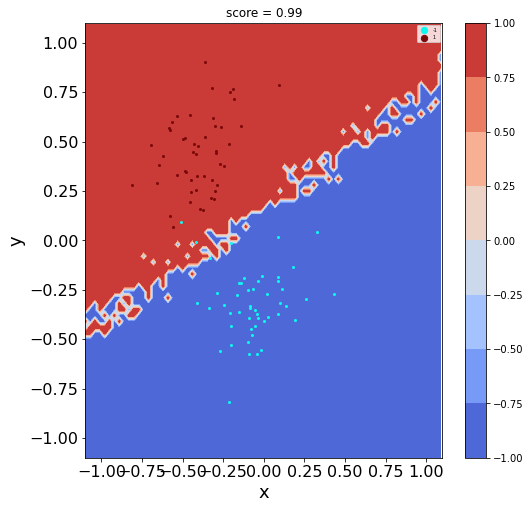

0.99

In [51]:
N_DRAW=100000
q_fit(0, 1000)

>>> Resolve linear system


100%|██████████| 800/800 [00:44<00:00, 17.86it/s]


>>> Scoring


100%|██████████| 100/100 [00:06<00:00, 15.57it/s]



>>>>>> quantum score =  1.0
>>> Plotting


100%|██████████| 74/74 [05:44<00:00,  4.66s/it]


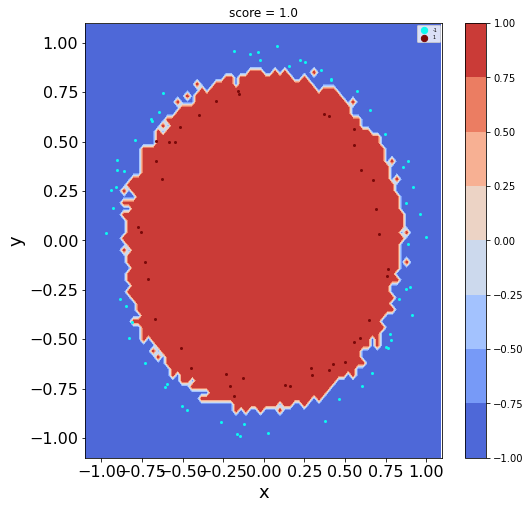

1.0

In [46]:
N_DRAW=100000
q_fit(1, 1000)

#### Special case: lunar data set

>>> Resolve linear system


100%|██████████| 800/800 [00:57<00:00, 14.00it/s]


>>> Scoring


100%|██████████| 100/100 [00:07<00:00, 14.00it/s]



>>>>>> quantum score =  0.81
>>> Plotting


100%|██████████| 74/74 [06:27<00:00,  5.23s/it]


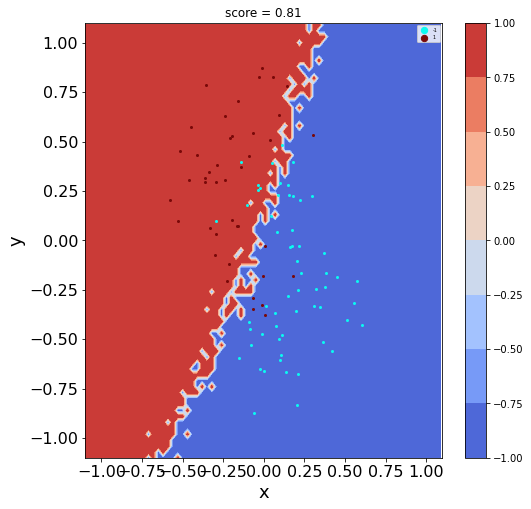

0.81

In [30]:
# include all imperfections
step = 6.5 * 1e-3 # increment of phase control
thermic_noise=1e-3 # thermic noise (includes other sources of noise)
N_DRAW=100000
q_fit(2, 1000)

>>> Resolve linear system


100%|██████████| 800/800 [00:10<00:00, 76.16it/s]


>>> Scoring


100%|██████████| 100/100 [00:01<00:00, 71.76it/s]



>>>>>> quantum score =  0.85
>>> Plotting


100%|██████████| 74/74 [01:09<00:00,  1.06it/s]


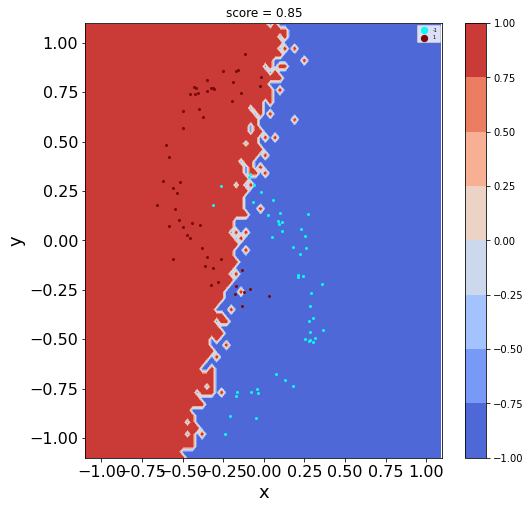

0.85

In [35]:
# only noise
N_DRAW=float("inf")
step = 6.5 * 1e-3 # increment of phase control
thermic_noise=1e-3 # thermic noise (includes other sources of noise)
q_fit(2, 1000)

>>> Resolve linear system


100%|██████████| 800/800 [00:56<00:00, 14.12it/s]


>>> Scoring


100%|██████████| 100/100 [00:07<00:00, 13.92it/s]



>>>>>> quantum score =  0.85
>>> Plotting


100%|██████████| 74/74 [06:23<00:00,  5.18s/it]


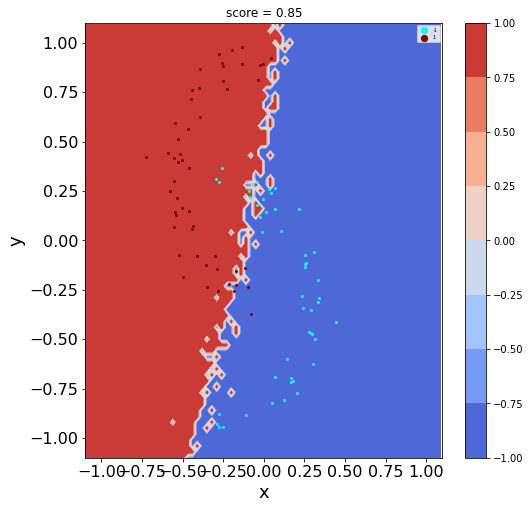

0.85

In [39]:
# only sampling
N_DRAW=100000
step=0
thermic_noise=0
q_fit(2, 1000)

>>> Resolve linear system


100%|██████████| 800/800 [08:55<00:00,  1.49it/s]


>>> Scoring


100%|██████████| 100/100 [01:08<00:00,  1.46it/s]



>>>>>> quantum score =  0.88
>>> Plotting


100%|██████████| 74/74 [1:01:09<00:00, 49.58s/it]


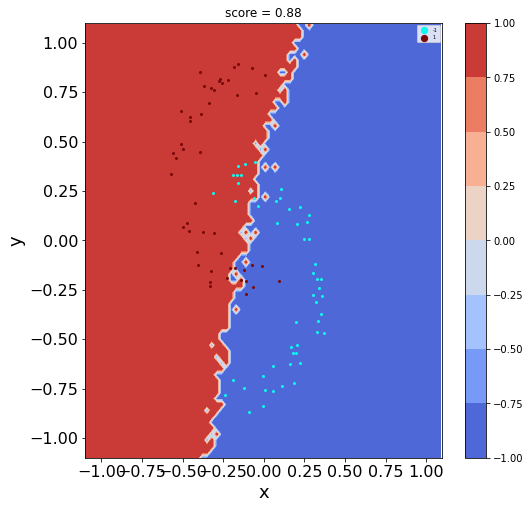

0.88

In [31]:
# only sampling
N_DRAW=1000000
step=0
thermic_noise=0
q_fit(2, 1000)

>>> Resolve linear system


100%|██████████| 800/800 [00:10<00:00, 74.12it/s]


>>> Scoring


100%|██████████| 100/100 [00:01<00:00, 70.10it/s]



>>>>>> quantum score =  0.99
>>> Plotting


100%|██████████| 74/74 [01:07<00:00,  1.10it/s]


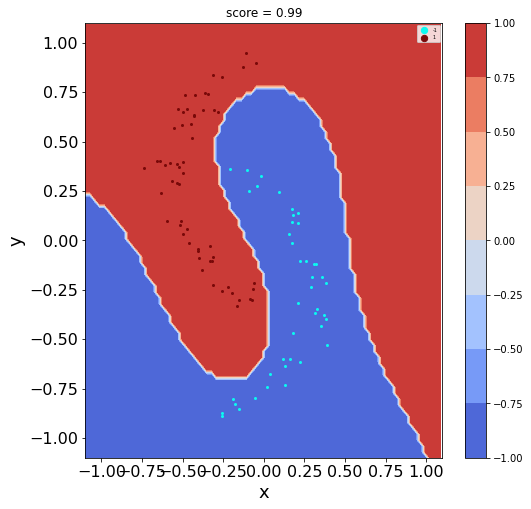

0.99

In [36]:
# perfect case
N_DRAW=float("inf")
step=0
thermic_noise=0
q_fit(2, 1000)

In order to assess the effect of noise, we plot the following graph.

>>> Resolve linear system


100%|██████████| 800/800 [00:10<00:00, 76.55it/s]


>>> Scoring


100%|██████████| 100/100 [00:01<00:00, 76.44it/s]


>>> Resolve linear system


100%|██████████| 800/800 [00:10<00:00, 78.13it/s]


>>> Scoring


100%|██████████| 100/100 [00:01<00:00, 73.18it/s]


>>> Resolve linear system


100%|██████████| 800/800 [00:10<00:00, 77.10it/s]


>>> Scoring


100%|██████████| 100/100 [00:01<00:00, 74.63it/s]


>>> Resolve linear system


100%|██████████| 800/800 [00:10<00:00, 76.49it/s]


>>> Scoring


100%|██████████| 100/100 [00:01<00:00, 72.83it/s]


>>> Resolve linear system


100%|██████████| 800/800 [00:10<00:00, 75.14it/s]


>>> Scoring


100%|██████████| 100/100 [00:01<00:00, 73.61it/s]


>>> Resolve linear system


100%|██████████| 800/800 [00:10<00:00, 77.11it/s]


>>> Scoring


100%|██████████| 100/100 [00:01<00:00, 79.99it/s]


>>> Resolve linear system


100%|██████████| 800/800 [00:09<00:00, 80.66it/s]


>>> Scoring


100%|██████████| 100/100 [00:01<00:00, 71.54it/s]


>>> Resolve linear system


100%|██████████| 800/800 [00:09<00:00, 81.97it/s]


>>> Scoring


100%|██████████| 100/100 [00:01<00:00, 75.22it/s]


>>> Resolve linear system


100%|██████████| 800/800 [00:10<00:00, 73.54it/s]


>>> Scoring


100%|██████████| 100/100 [00:01<00:00, 74.97it/s]


>>> Resolve linear system


100%|██████████| 800/800 [00:09<00:00, 83.76it/s]


>>> Scoring


100%|██████████| 100/100 [00:01<00:00, 82.45it/s]


>>> Resolve linear system


100%|██████████| 800/800 [00:10<00:00, 78.59it/s]


>>> Scoring


100%|██████████| 100/100 [00:01<00:00, 77.98it/s]


>>> Resolve linear system


100%|██████████| 800/800 [00:09<00:00, 80.12it/s]


>>> Scoring


100%|██████████| 100/100 [00:01<00:00, 81.11it/s]


>>> Resolve linear system


100%|██████████| 800/800 [00:10<00:00, 78.75it/s]


>>> Scoring


100%|██████████| 100/100 [00:01<00:00, 79.59it/s]


>>> Resolve linear system


100%|██████████| 800/800 [00:10<00:00, 78.50it/s]


>>> Scoring


100%|██████████| 100/100 [00:01<00:00, 77.00it/s]


>>> Resolve linear system


100%|██████████| 800/800 [00:10<00:00, 78.36it/s]


>>> Scoring


100%|██████████| 100/100 [00:01<00:00, 75.58it/s]


>>> Resolve linear system


100%|██████████| 800/800 [00:10<00:00, 79.57it/s]


>>> Scoring


100%|██████████| 100/100 [00:01<00:00, 79.65it/s]


>>> Resolve linear system


100%|██████████| 800/800 [00:09<00:00, 81.97it/s]


>>> Scoring


100%|██████████| 100/100 [00:01<00:00, 80.21it/s]


>>> Resolve linear system


100%|██████████| 800/800 [00:09<00:00, 81.23it/s]


>>> Scoring


100%|██████████| 100/100 [00:01<00:00, 78.85it/s]


>>> Resolve linear system


100%|██████████| 800/800 [00:10<00:00, 76.58it/s]


>>> Scoring


100%|██████████| 100/100 [00:01<00:00, 77.13it/s]


>>> Resolve linear system


100%|██████████| 800/800 [00:10<00:00, 77.16it/s]


>>> Scoring


100%|██████████| 100/100 [00:01<00:00, 77.62it/s]


>>> Resolve linear system


100%|██████████| 800/800 [00:10<00:00, 77.35it/s]


>>> Scoring


100%|██████████| 100/100 [00:01<00:00, 78.00it/s]


>>> Resolve linear system


100%|██████████| 800/800 [00:09<00:00, 80.05it/s]


>>> Scoring


100%|██████████| 100/100 [00:01<00:00, 70.46it/s]


>>> Resolve linear system


100%|██████████| 800/800 [00:10<00:00, 76.44it/s]


>>> Scoring


100%|██████████| 100/100 [00:01<00:00, 79.29it/s]


>>> Resolve linear system


100%|██████████| 800/800 [00:10<00:00, 78.45it/s]


>>> Scoring


100%|██████████| 100/100 [00:01<00:00, 75.33it/s]


>>> Resolve linear system


100%|██████████| 800/800 [00:10<00:00, 77.81it/s]


>>> Scoring


100%|██████████| 100/100 [00:01<00:00, 76.29it/s]


>>> Resolve linear system


100%|██████████| 800/800 [00:11<00:00, 70.14it/s]


>>> Scoring


100%|██████████| 100/100 [00:01<00:00, 75.64it/s]


>>> Resolve linear system


100%|██████████| 800/800 [00:09<00:00, 81.42it/s]


>>> Scoring


100%|██████████| 100/100 [00:01<00:00, 74.69it/s]


>>> Resolve linear system


100%|██████████| 800/800 [00:10<00:00, 75.26it/s]


>>> Scoring


100%|██████████| 100/100 [00:01<00:00, 80.26it/s]


>>> Resolve linear system


100%|██████████| 800/800 [00:10<00:00, 79.44it/s]


>>> Scoring


100%|██████████| 100/100 [00:01<00:00, 79.57it/s]


>>> Resolve linear system


100%|██████████| 800/800 [00:10<00:00, 77.35it/s]


>>> Scoring


100%|██████████| 100/100 [00:01<00:00, 81.01it/s]


>>> Resolve linear system


100%|██████████| 800/800 [00:10<00:00, 77.36it/s]


>>> Scoring


100%|██████████| 100/100 [00:01<00:00, 75.54it/s]


>>> Resolve linear system


100%|██████████| 800/800 [00:11<00:00, 72.53it/s]


>>> Scoring


100%|██████████| 100/100 [00:01<00:00, 75.47it/s]


>>> Resolve linear system


100%|██████████| 800/800 [00:10<00:00, 79.93it/s]


>>> Scoring


100%|██████████| 100/100 [00:01<00:00, 75.42it/s]


>>> Resolve linear system


100%|██████████| 800/800 [00:09<00:00, 81.37it/s]


>>> Scoring


100%|██████████| 100/100 [00:01<00:00, 79.57it/s]


>>> Resolve linear system


100%|██████████| 800/800 [00:09<00:00, 80.51it/s]


>>> Scoring


100%|██████████| 100/100 [00:01<00:00, 78.32it/s]


>>> Resolve linear system


100%|██████████| 800/800 [00:10<00:00, 77.46it/s]


>>> Scoring


100%|██████████| 100/100 [00:01<00:00, 74.76it/s]


>>> Resolve linear system


100%|██████████| 800/800 [00:10<00:00, 75.38it/s]


>>> Scoring


100%|██████████| 100/100 [00:01<00:00, 83.21it/s]


>>> Resolve linear system


100%|██████████| 800/800 [00:09<00:00, 82.55it/s]


>>> Scoring


100%|██████████| 100/100 [00:01<00:00, 73.98it/s]


>>> Resolve linear system


100%|██████████| 800/800 [00:10<00:00, 75.58it/s]


>>> Scoring


100%|██████████| 100/100 [00:01<00:00, 73.44it/s]


>>> Resolve linear system


100%|██████████| 800/800 [00:10<00:00, 75.05it/s]


>>> Scoring


100%|██████████| 100/100 [00:01<00:00, 73.01it/s]


>>> Resolve linear system


100%|██████████| 800/800 [00:11<00:00, 71.83it/s]


>>> Scoring


100%|██████████| 100/100 [00:01<00:00, 80.50it/s]


>>> Resolve linear system


100%|██████████| 800/800 [00:09<00:00, 84.91it/s]


>>> Scoring


100%|██████████| 100/100 [00:01<00:00, 77.41it/s]


>>> Resolve linear system


100%|██████████| 800/800 [00:10<00:00, 77.97it/s]


>>> Scoring


100%|██████████| 100/100 [00:01<00:00, 76.76it/s]


>>> Resolve linear system


100%|██████████| 800/800 [00:10<00:00, 78.47it/s]


>>> Scoring


100%|██████████| 100/100 [00:01<00:00, 76.88it/s]


>>> Resolve linear system


100%|██████████| 800/800 [00:10<00:00, 78.17it/s]


>>> Scoring


100%|██████████| 100/100 [00:01<00:00, 80.94it/s]


>>> Resolve linear system


100%|██████████| 800/800 [00:09<00:00, 81.66it/s]


>>> Scoring


100%|██████████| 100/100 [00:01<00:00, 78.49it/s]


>>> Resolve linear system


100%|██████████| 800/800 [00:10<00:00, 79.70it/s]


>>> Scoring


100%|██████████| 100/100 [00:01<00:00, 79.56it/s]


>>> Resolve linear system


100%|██████████| 800/800 [00:09<00:00, 83.85it/s]


>>> Scoring


100%|██████████| 100/100 [00:01<00:00, 81.91it/s]


>>> Resolve linear system


100%|██████████| 800/800 [00:09<00:00, 83.39it/s]


>>> Scoring


100%|██████████| 100/100 [00:01<00:00, 82.39it/s]


>>> Resolve linear system


100%|██████████| 800/800 [00:09<00:00, 80.59it/s]


>>> Scoring


100%|██████████| 100/100 [00:01<00:00, 81.06it/s]


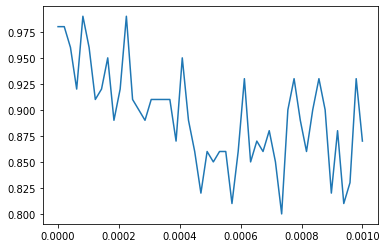

In [29]:
# thermic noise effect
N_DRAW=float("inf")
step=0
X = np.linspace(0,1e-3, num = 50)
plt.plot(X, [q_fit_short(x) for x in X])
plt.show()

We obtain the result below.

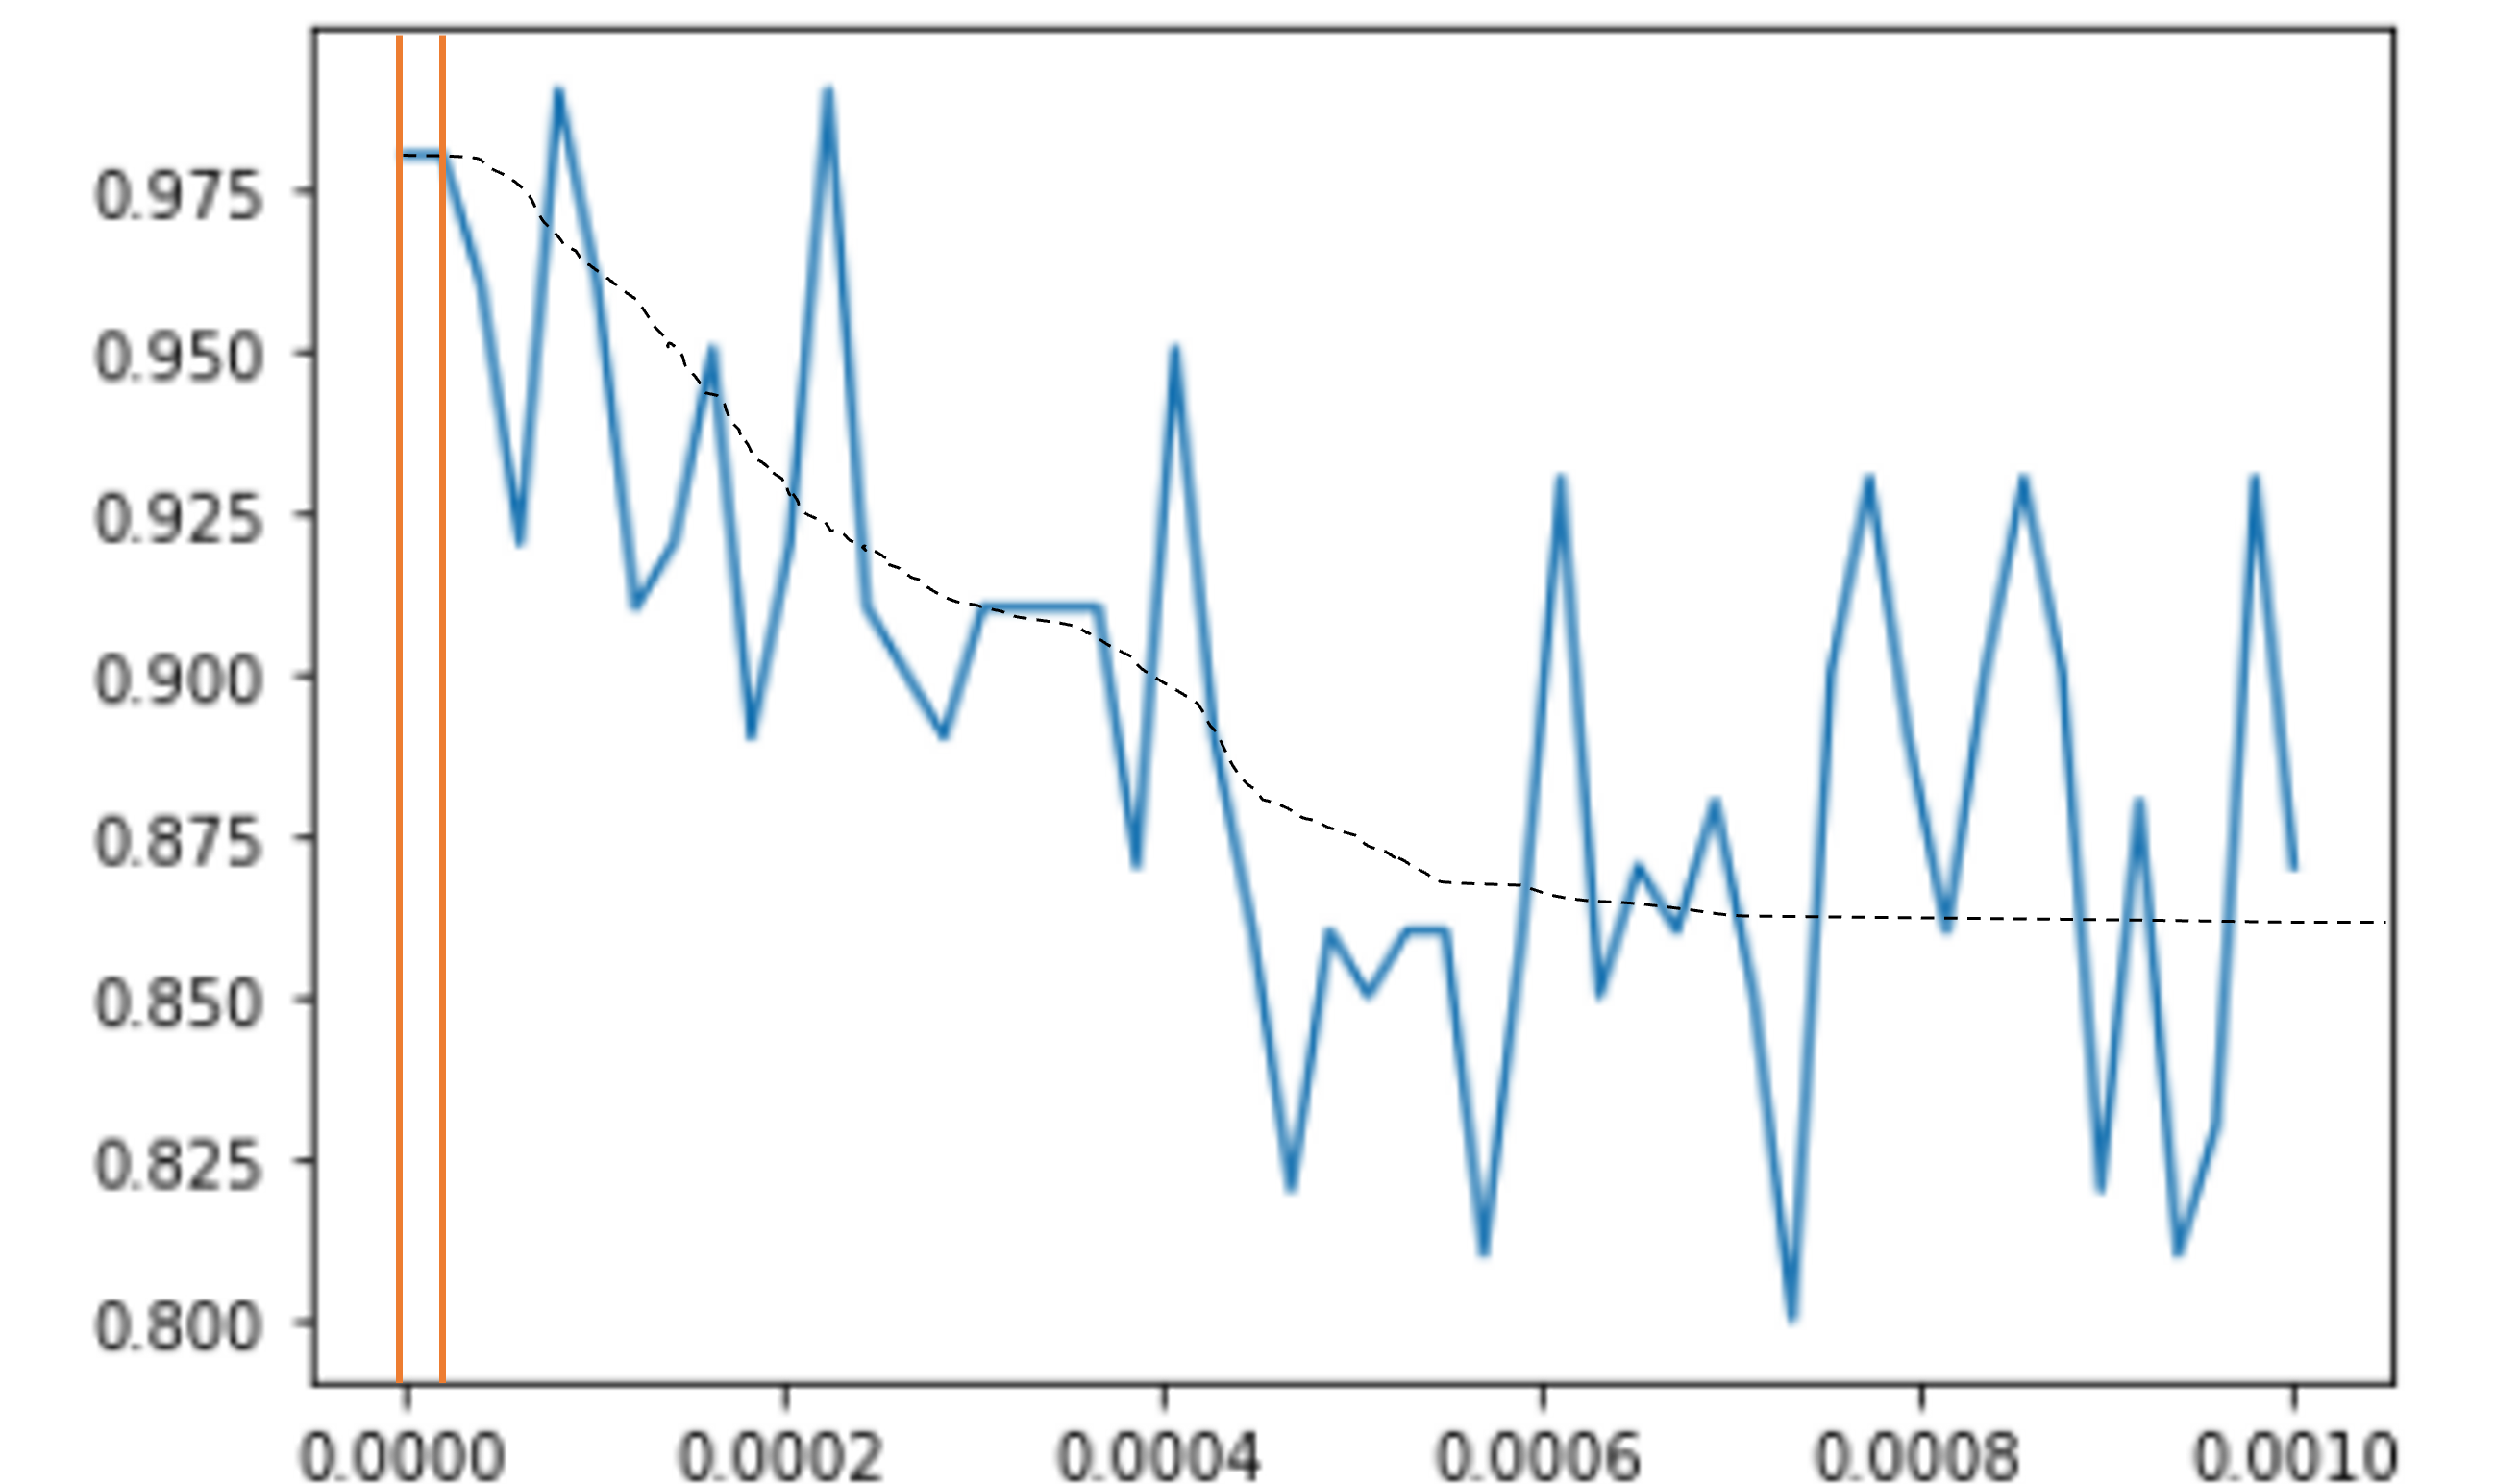

From the graph above, we can deduce the following facts:

1. The loss of quality of the fitting happens with small values of noise (nearly at $2 \times 10^{-5} \text{rad}$).
2. The classification score oscillates ($\pm 0.05$).
3. The average score seems to have a plateau at $0.0006 \ \text{rad}$ at a value of $0.87$.

>>> Resolve linear system


100%|██████████| 800/800 [00:10<00:00, 77.58it/s]


>>> Scoring


100%|██████████| 100/100 [00:01<00:00, 80.81it/s]



>>>>>> quantum score =  0.98
>>> Plotting


100%|██████████| 74/74 [01:05<00:00,  1.13it/s]


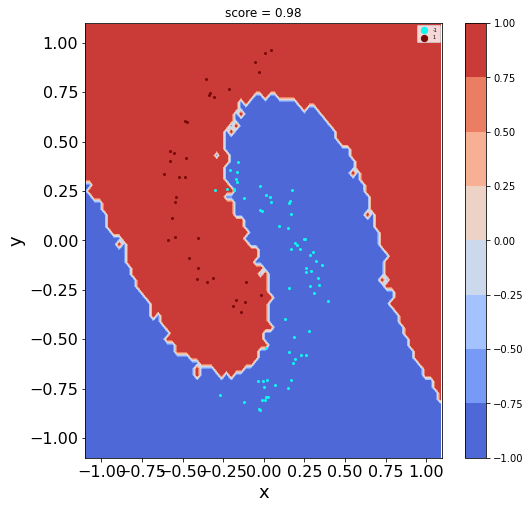

0.98

In [32]:
N_DRAW=float("inf")
step=0
thermic_noise=1e-5
q_fit(2, 1000)

>>> Resolve linear system


100%|██████████| 800/800 [00:09<00:00, 80.02it/s]


>>> Scoring


100%|██████████| 100/100 [00:01<00:00, 77.92it/s]



>>>>>> quantum score =  0.93
>>> Plotting


100%|██████████| 74/74 [01:06<00:00,  1.11it/s]


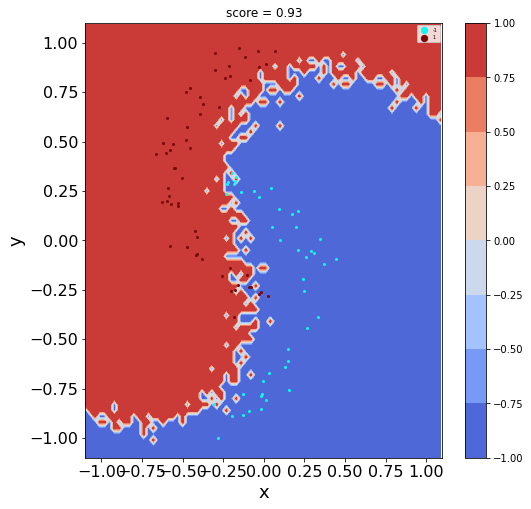

0.93

In [33]:
N_DRAW=float("inf")
step=0
thermic_noise=5e-5
q_fit(2, 1000)